### Création de variables combinées

Les 3 colonnes de retard (30-59, 60-89, 90+ jours) sont très corrélées donc je vais faire une somme totale des incidents de paiement :

In [12]:
import pandas as pd
# load cleaned data
df = pd.read_csv("../data/processed/cleaned_data.csv")

In [13]:
df["TotalLatePayments"] = (
    df["NumberOfTime30-59DaysPastDueNotWorse"] +
    df["NumberOfTime60-89DaysPastDueNotWorse"] +
    df["NumberOfTimes90DaysLate"]
)
# Cela réduit la redondance, diminue la dimensionnalité, et améliore la clarté.

In [14]:
numeric_features = [
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfDependents",
    "TotalLatePayments"
]

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Pipeline de transformation des variables numériques
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Assembleur de prétraitements
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features)
], remainder="passthrough")  # conserve les autres colonnes

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop("SeriousDlqin2yrs", axis=1)
y = df["SeriousDlqin2yrs"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# entraînement et d’évaluation
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

results = {}

for name, clf in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),  # ton préprocessing avec standardisation
        ("classifier", clf)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        "model": pipeline,
        "auc": auc,
        "f1": f1,
        "confusion_matrix": cm
    }
    
    print(f"\n🎯 {name}")
    print("AUC:", round(auc, 3))
    print("F1-score:", round(f1, 3))
    print("Confusion matrix:\n", cm)
    print(classification_report(y_test, y_pred))


🎯 Logistic Regression
AUC: 0.711
F1-score: 0.086
Confusion matrix:
 [[27932    63]
 [ 1912    93]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27995
           1       0.60      0.05      0.09      2005

    accuracy                           0.93     30000
   macro avg       0.77      0.52      0.53     30000
weighted avg       0.91      0.93      0.91     30000


🎯 Random Forest
AUC: 0.845
F1-score: 0.273
Confusion matrix:
 [[27704   291]
 [ 1642   363]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.56      0.18      0.27      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000


🎯 XGBoost
AUC: 0.86
F1-score: 0.291
Confusion matrix:
 [[27649   346]
 [ 1604   401]]
              precision    recall  f1-score   support

          

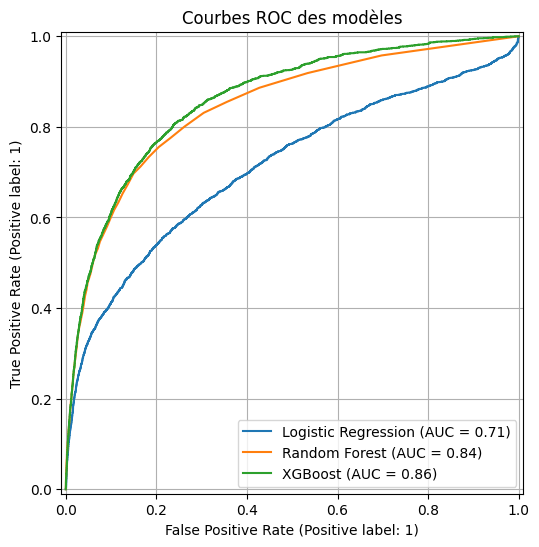

In [19]:
plt.figure(figsize=(12, 6))

for name, res in results.items():
    RocCurveDisplay.from_estimator(res["model"], X_test, y_test, name=name, ax=plt.gca())

plt.title("Courbes ROC des modèles")
plt.grid(True)
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="roc_auc", cv=5)
grid.fit(X_train, y_train)

print("Best AUC:", grid.best_score_)
print("Best params:", grid.best_params_)


Best AUC: 0.8638345594686754
Best params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}


D'après les resultats le mode XGBOOST de meilleur résultat donc je vais garder ce model pour la suite

In [21]:
import joblib

# Enregistrer le meilleur modèle trouvé par la recherche sur grille
joblib.dump(grid.best_estimator_, "../model/xgboost_pipeline.pkl")

['../model/xgboost_pipeline.pkl']

In [22]:
# Enregistrement des données traitées pour la modélisation
df.to_csv('../data/processed/train_clean.csv', index=False)